# JD Coupon Distribution System

## 1. Load the Dataset

In [134]:
# import modules
import  warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_selection import RFE

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier as XGBC

from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from collections import Counter

In [3]:
data = pd.read_csv(r'F:\Data_Science\Machine_learning\zhinanzheliuxue\Jing_dong\datas.csv',)

In [4]:
data.head()

,id,campaign_id,coupon_id,customer_id,redemption_status,brand,brand_type,category,cd_sum,coupon_discount_x,...,no_of_items,month,other_discount_y,quantity_y,selling_price_y,cdd_sum,customer_id_count,odd_sum,qa_sum,pprice_sum
0,1,13,27,1053,0,1105,0,6,-5349.93,-1.241694,...,208,5,-25.583099,340.487097,163.966826,-89.05,310,-7930.760842,105551,50829.715972
1,2,13,116,48,0,56,1,6,0.00,0.000000,...,244,6,-20.013685,31.540260,188.638474,-1237.79,385,-7705.268702,12143,72625.812434
2,6,9,635,205,0,560,0,11,-605.54,-2.987321,...,533,3,-12.873370,1.392784,112.067666,-2145.72,970,-12487.169143,1351,108705.636349
3,7,13,644,1050,0,611,0,6,-17.81,-4.452500,...,216,8,-12.880868,1.291139,100.896997,-178.10,237,-3052.765833,306,23912.588333
4,9,8,1017,1489,0,1558,0,6,-569.92,-0.198055,...,327,5,-12.264174,247.443060,85.016352,-265.01,562,-6892.466021,139063,47779.189609


In [6]:
# Distribution of label 'redemption_status'
data['redemption_status'].value_counts()

0    77640
1      729
Name: redemption_status, dtype: int64

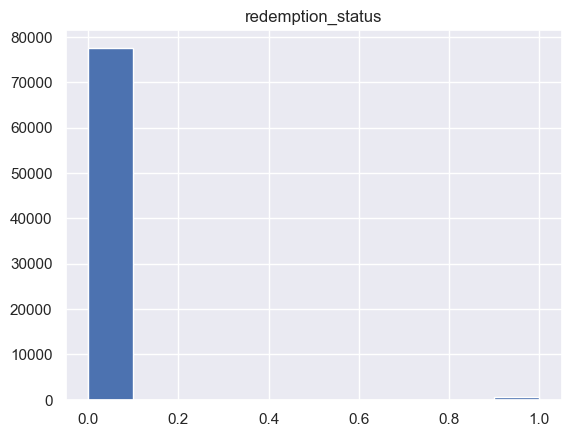

In [7]:
plt.hist(data['redemption_status'])
plt.title('redemption_status')
plt.show()

Lable is unevenly distributed, use ROC-AUC as metric

## 2. EDA

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78369 entries, 0 to 78368
Data columns (total 46 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   78369 non-null  int64  
 1   campaign_id          78369 non-null  int64  
 2   coupon_id            78369 non-null  int64  
 3   customer_id          78369 non-null  int64  
 4   redemption_status    78369 non-null  int64  
 5   brand                78369 non-null  int64  
 6   brand_type           78369 non-null  int64  
 7   category             78369 non-null  int64  
 8   cd_sum               78369 non-null  float64
 9   coupon_discount_x    78369 non-null  float64
 10  coupon_used_x        78369 non-null  float64
 11  item_counts          78369 non-null  int64  
 12  no_of_customers      78369 non-null  float64
 13  od_sum               78369 non-null  float64
 14  other_discount_x     78369 non-null  float64
 15  price_sum            78369 non-null 

In [9]:
data.describe(include = 'all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,78369.0,NaN,NaN,NaN,64347.975449,37126.440855,1.0,32260.0,64318.0,96577.0,128595.0
campaign_id,78369.0,NaN,NaN,NaN,13.974441,8.019215,1.0,8.0,13.0,13.0,30.0
coupon_id,78369.0,NaN,NaN,NaN,566.363243,329.966054,1.0,280.0,597.0,857.0,1115.0
customer_id,78369.0,NaN,NaN,NaN,787.451888,456.811339,1.0,399.0,781.0,1190.0,1582.0
redemption_status,78369.0,NaN,NaN,NaN,0.009302,0.095999,0.0,0.0,0.0,0.0,1.0
brand,78369.0,NaN,NaN,NaN,1053.349067,1332.569207,1.0,58.0,681.0,1193.0,5395.0
brand_type,78369.0,NaN,NaN,NaN,0.215251,0.410999,0.0,0.0,0.0,0.0,1.0
category,78369.0,NaN,NaN,NaN,7.419528,2.560285,1.0,6.0,6.0,11.0,16.0
cd_sum,78369.0,NaN,NaN,NaN,-1410.408817,7152.120464,-113627.34,-756.56,-213.72,0.0,0.0
coupon_discount_x,78369.0,NaN,NaN,NaN,-2.26592,5.814932,-71.24,-2.101764,-0.608013,0.0,0.0


### 2.1 Missing value

In [10]:
# check if there is missing data
data.isnull().sum()

id                         0
campaign_id                0
coupon_id                  0
customer_id                0
redemption_status          0
brand                      0
brand_type                 0
category                   0
cd_sum                     0
coupon_discount_x          0
coupon_used_x              0
item_counts                0
no_of_customers            0
od_sum                     0
other_discount_x           0
price_sum                  0
qu_sum                     0
quantity_x                 0
selling_price_x            0
t_counts                   0
total_discount_mean        0
total_discount_sum         0
campaign_type              0
start_date                 0
end_date                   0
campaign_duration          0
age_range              34708
marital_status         34708
rented                 34708
family_size            34708
no_of_children         34708
income_bracket         34708
coupon_discount_y          0
coupon_used_y              0
day           

In [18]:
# print missiong ratio of each feature
for i in ['age_range','marital_status', 'rented', 'family_size', 'no_of_children', 'income_bracket']:
    print('{0:15s} \'s missing ratio is {1}'.format(i, round(data[i].isnull().sum() / len(data[i]), 2)))

age_range       's missing ratio is 0.44
marital_status  's missing ratio is 0.44
rented          's missing ratio is 0.44
family_size     's missing ratio is 0.44
no_of_children  's missing ratio is 0.44
income_bracket  's missing ratio is 0.44


feature: age_range, marital_status, rented, family_size, no_of_children has missing values, percentage of data missiong is 44%, so we cannot simply delete them.

In [20]:
# check the average, median and mode of each feature
for i in ['age_range','marital_status', 'rented', 'family_size', 'no_of_children', 'income_bracket']:
    print(i)
    print('mean: {}'.format(data[i].mean()))
    print('median: {}'.format(data[i].median()))
    print('mode: {}'.format(data[i].mode()[0]))
    print('============================')

age_range
mean: 2.4339341746638876
median: 3.0
mode: 3.0
marital_status
mean: 0.3947687867891253
median: 0.0
mode: 0.0
rented
mean: 0.05737385767618699
median: 0.0
mode: 0.0
family_size
mean: 2.233572295641419
median: 2.0
mode: 2.0
no_of_children
mean: 0.6169350221021048
median: 0.0
mode: 0.0
income_bracket
mean: 4.802478184191842
median: 5.0
mode: 5.0


In [21]:
# fill missing value with mode
for i in ['age_range','marital_status', 'rented', 'family_size', 'no_of_children', 'income_bracket']:
    data[i].fillna(data[i].mode()[0],inplace = True)

In [23]:
# chech if there is any missing value
data.isnull().sum().sum()

0

### 2.2 Duplicates

In [24]:
data[data.duplicated()]

,id,campaign_id,coupon_id,customer_id,redemption_status,brand,brand_type,category,cd_sum,coupon_discount_x,...,no_of_items,month,other_discount_y,quantity_y,selling_price_y,cdd_sum,customer_id_count,odd_sum,qa_sum,pprice_sum


There is no duplicates in this dataset

### 2.3 Handle with Dates

In [26]:
# Calculate durations
duration = (pd.to_datetime(data["end_date"], format='%Y-%m-%d')) - (pd.to_datetime(data["start_date"], format='%Y-%m-%d'))

# change data type to int
duration.apply(lambda x: int(str(x).split(' ')[0]))

# add a new column to put 'duration' in the table
data['duration'] = duration.apply(lambda x: int(str(x).split(' ')[0]))

# delete the original 'start_date' and 'end_date'
data.drop(['start_date', 'end_date'], axis = 1, inplace = True)


## 3. Feature Engineering

### 3.1 Get features and lable

In [28]:
# features
x = data.drop(['redemption_status', 'id', 'campaign_id', 'coupon_id', 'customer_id'], axis = 1)
x.shape

(78369, 40)

In [29]:
# label
y  = data['redemption_status']

### 3.2 Divide training set and testing set

In [37]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(x, y, test_size = 0.3, random_state = 420)

# Reset index
for i in [Xtrain, Xtest, Ytrain, Ytest]:
    i.index = range(i.shape[0])

In [40]:
# check shape of training and test set
print('training set: {}'.format(Xtrain.shape))
print('test set: {}'.format(Xtest.shape))

training set: (54858, 40)
test set: (23511, 40)


### 3.3 Normalization

In [43]:
# View the magnitude of each feature in the training set
Xtrain.describe().T

,count,mean,std,min,25%,50%,75%,max
brand,54858.0,1052.217616,1.332256e+03,1.000000e+00,57.000000,681.000000,1193.000000,5.395000e+03
brand_type,54858.0,0.216924,4.121540e-01,0.000000e+00,0.000000,0.000000,0.000000,1.000000e+00
category,54858.0,7.417496,2.558149e+00,1.000000e+00,6.000000,6.000000,11.000000,1.600000e+01
cd_sum,54858.0,-1413.010966,7.217785e+03,-1.136273e+05,-746.220000,-213.720000,0.000000,0.000000e+00
coupon_discount_x,54858.0,-2.237361,5.739783e+00,-7.124000e+01,-2.101764,-0.582909,0.000000,0.000000e+00
coupon_used_x,54858.0,42.353093,2.083508e+02,0.000000e+00,0.000000,5.000000,22.000000,2.661000e+03
item_counts,54858.0,83.579843,6.216235e+02,1.000000e+00,5.000000,12.000000,30.000000,1.181300e+04
no_of_customers,54858.0,17.533794,1.350321e+01,1.000000e+00,7.111111,15.000000,24.333333,1.185714e+02
od_sum,54858.0,-35021.925801,2.161543e+05,-3.259658e+06,-12273.300000,-3614.690000,-983.110000,0.000000e+00
other_discount_x,54858.0,-20.723663,2.129728e+01,-4.814993e+02,-26.472857,-15.697097,-8.211766,0.000000e+00


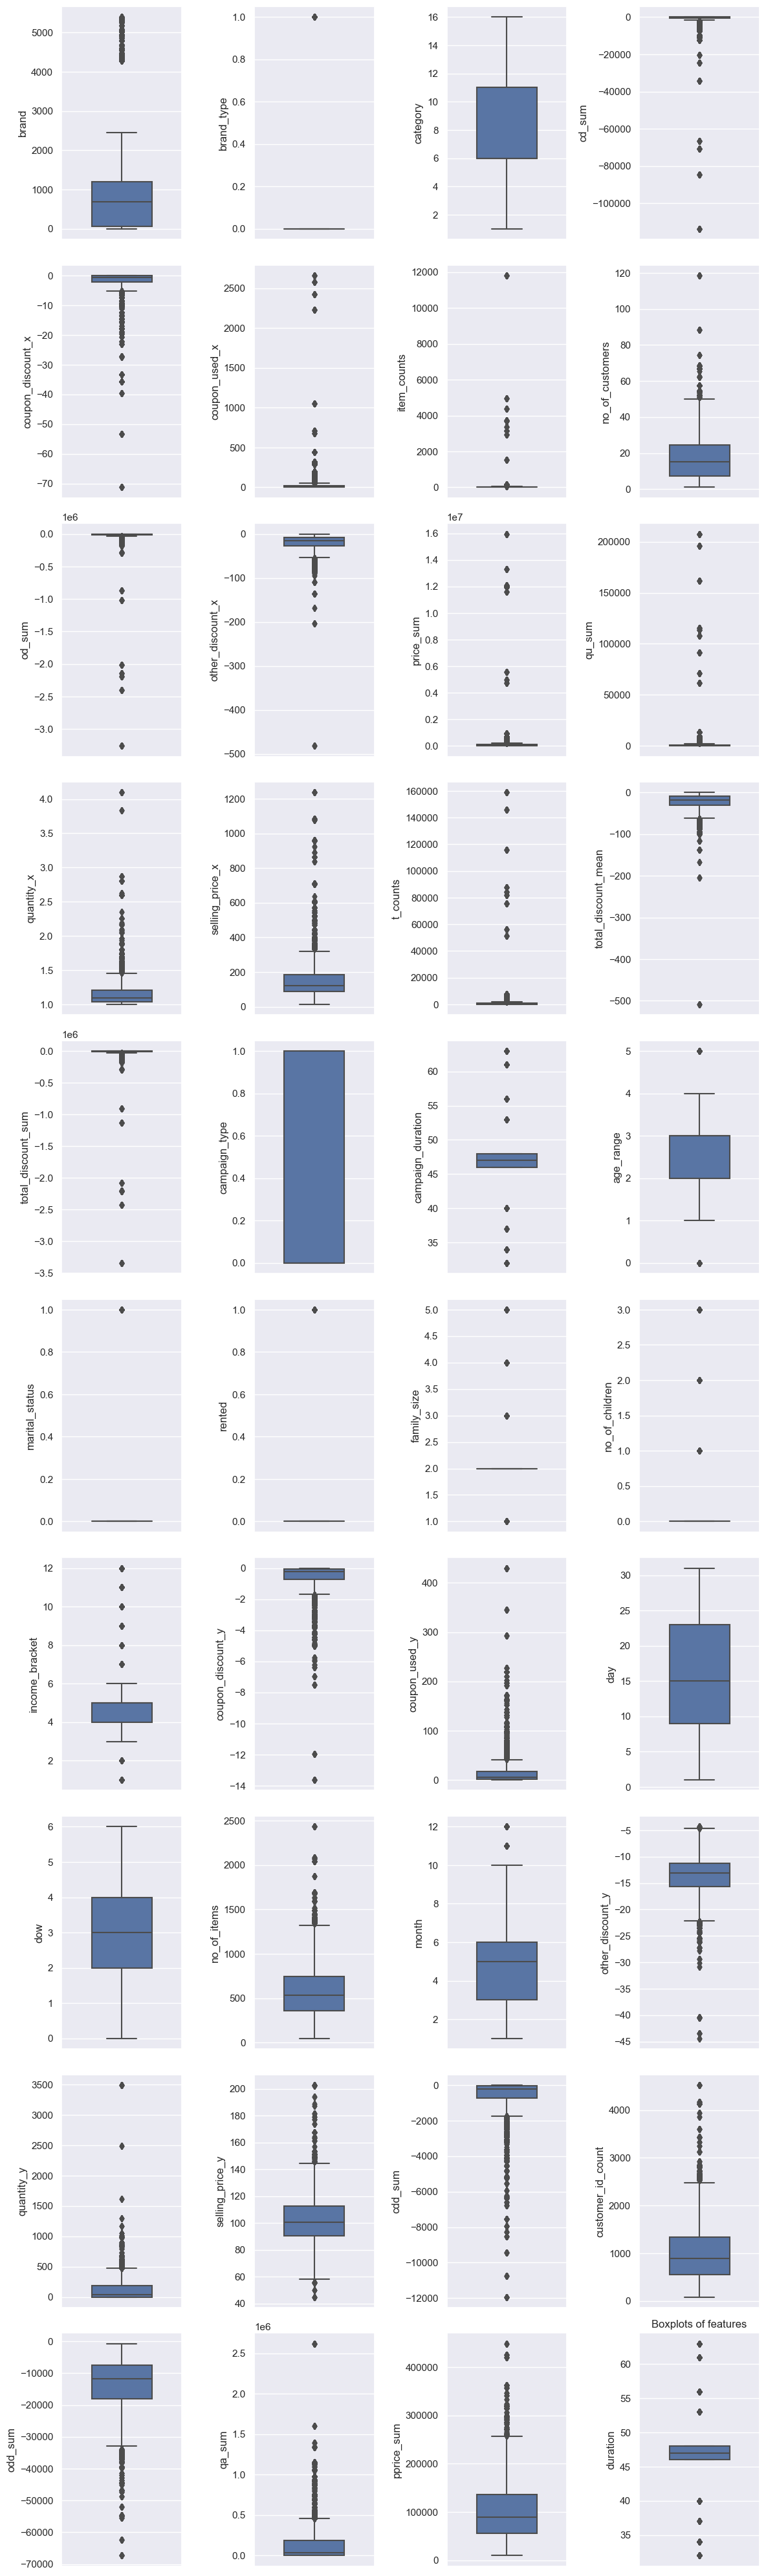

In [50]:
# Draw boxplots of discrete features
num_feature = Xtrain.shape[1]

ncol = 4
nrow = 10

fig, axes = plt.subplots(nrow, ncol, figsize = (12, 40))

for i in range(num_feature):
    column = Xtrain.columns[i]
    r, c = i // ncol, i % ncol
    ax = axes[r, c]
    sns.boxplot(y = Xtrain[column], ax = ax, width = 0.5)

plt.title('Boxplots of features')
fig.tight_layout()
plt.show()

By plotting the boxplots, we can see that the magnitudes of the features are extremely diverse from one another, there are also negative features, and the discrete values are not distributed uniformly. So we use normalization to pre-process the data

In [52]:
# Normalization
scaler = MinMaxScaler()
scaled_Xtrain = scaler.fit_transform(Xtrain)
scaled_Xtest = scaler.transform(Xtest)       # use training set to normalize test set
Xtrain_ = pd.DataFrame(data = scaled_Xtrain, columns = Xtrain.columns)
Xtest_ = pd.DataFrame(data = scaled_Xtest, columns = Xtest.columns)     # convert to dataframe

# Display dataset after normalization
Xtrain_.describe().T

,count,mean,std,min,25%,50%,75%,max
brand,54858.0,0.194886,0.246988,0.0,0.010382,0.126066,0.220986,1.0
brand_type,54858.0,0.216924,0.412154,0.0,0.000000,0.000000,0.000000,1.0
category,54858.0,0.427833,0.170543,0.0,0.333333,0.333333,0.666667,1.0
cd_sum,54858.0,0.987565,0.063522,0.0,0.993433,0.998119,1.000000,1.0
coupon_discount_x,54858.0,0.968594,0.080570,0.0,0.970497,0.991818,1.000000,1.0
coupon_used_x,54858.0,0.015916,0.078298,0.0,0.000000,0.001879,0.008268,1.0
item_counts,54858.0,0.006991,0.052626,0.0,0.000339,0.000931,0.002455,1.0
no_of_customers,54858.0,0.140628,0.114851,0.0,0.051978,0.119077,0.198461,1.0
od_sum,54858.0,0.989256,0.066312,0.0,0.996235,0.998891,0.999698,1.0
other_discount_x,54858.0,0.956960,0.044231,0.0,0.945020,0.967400,0.982945,1.0


### 3.4 Convert tilted features

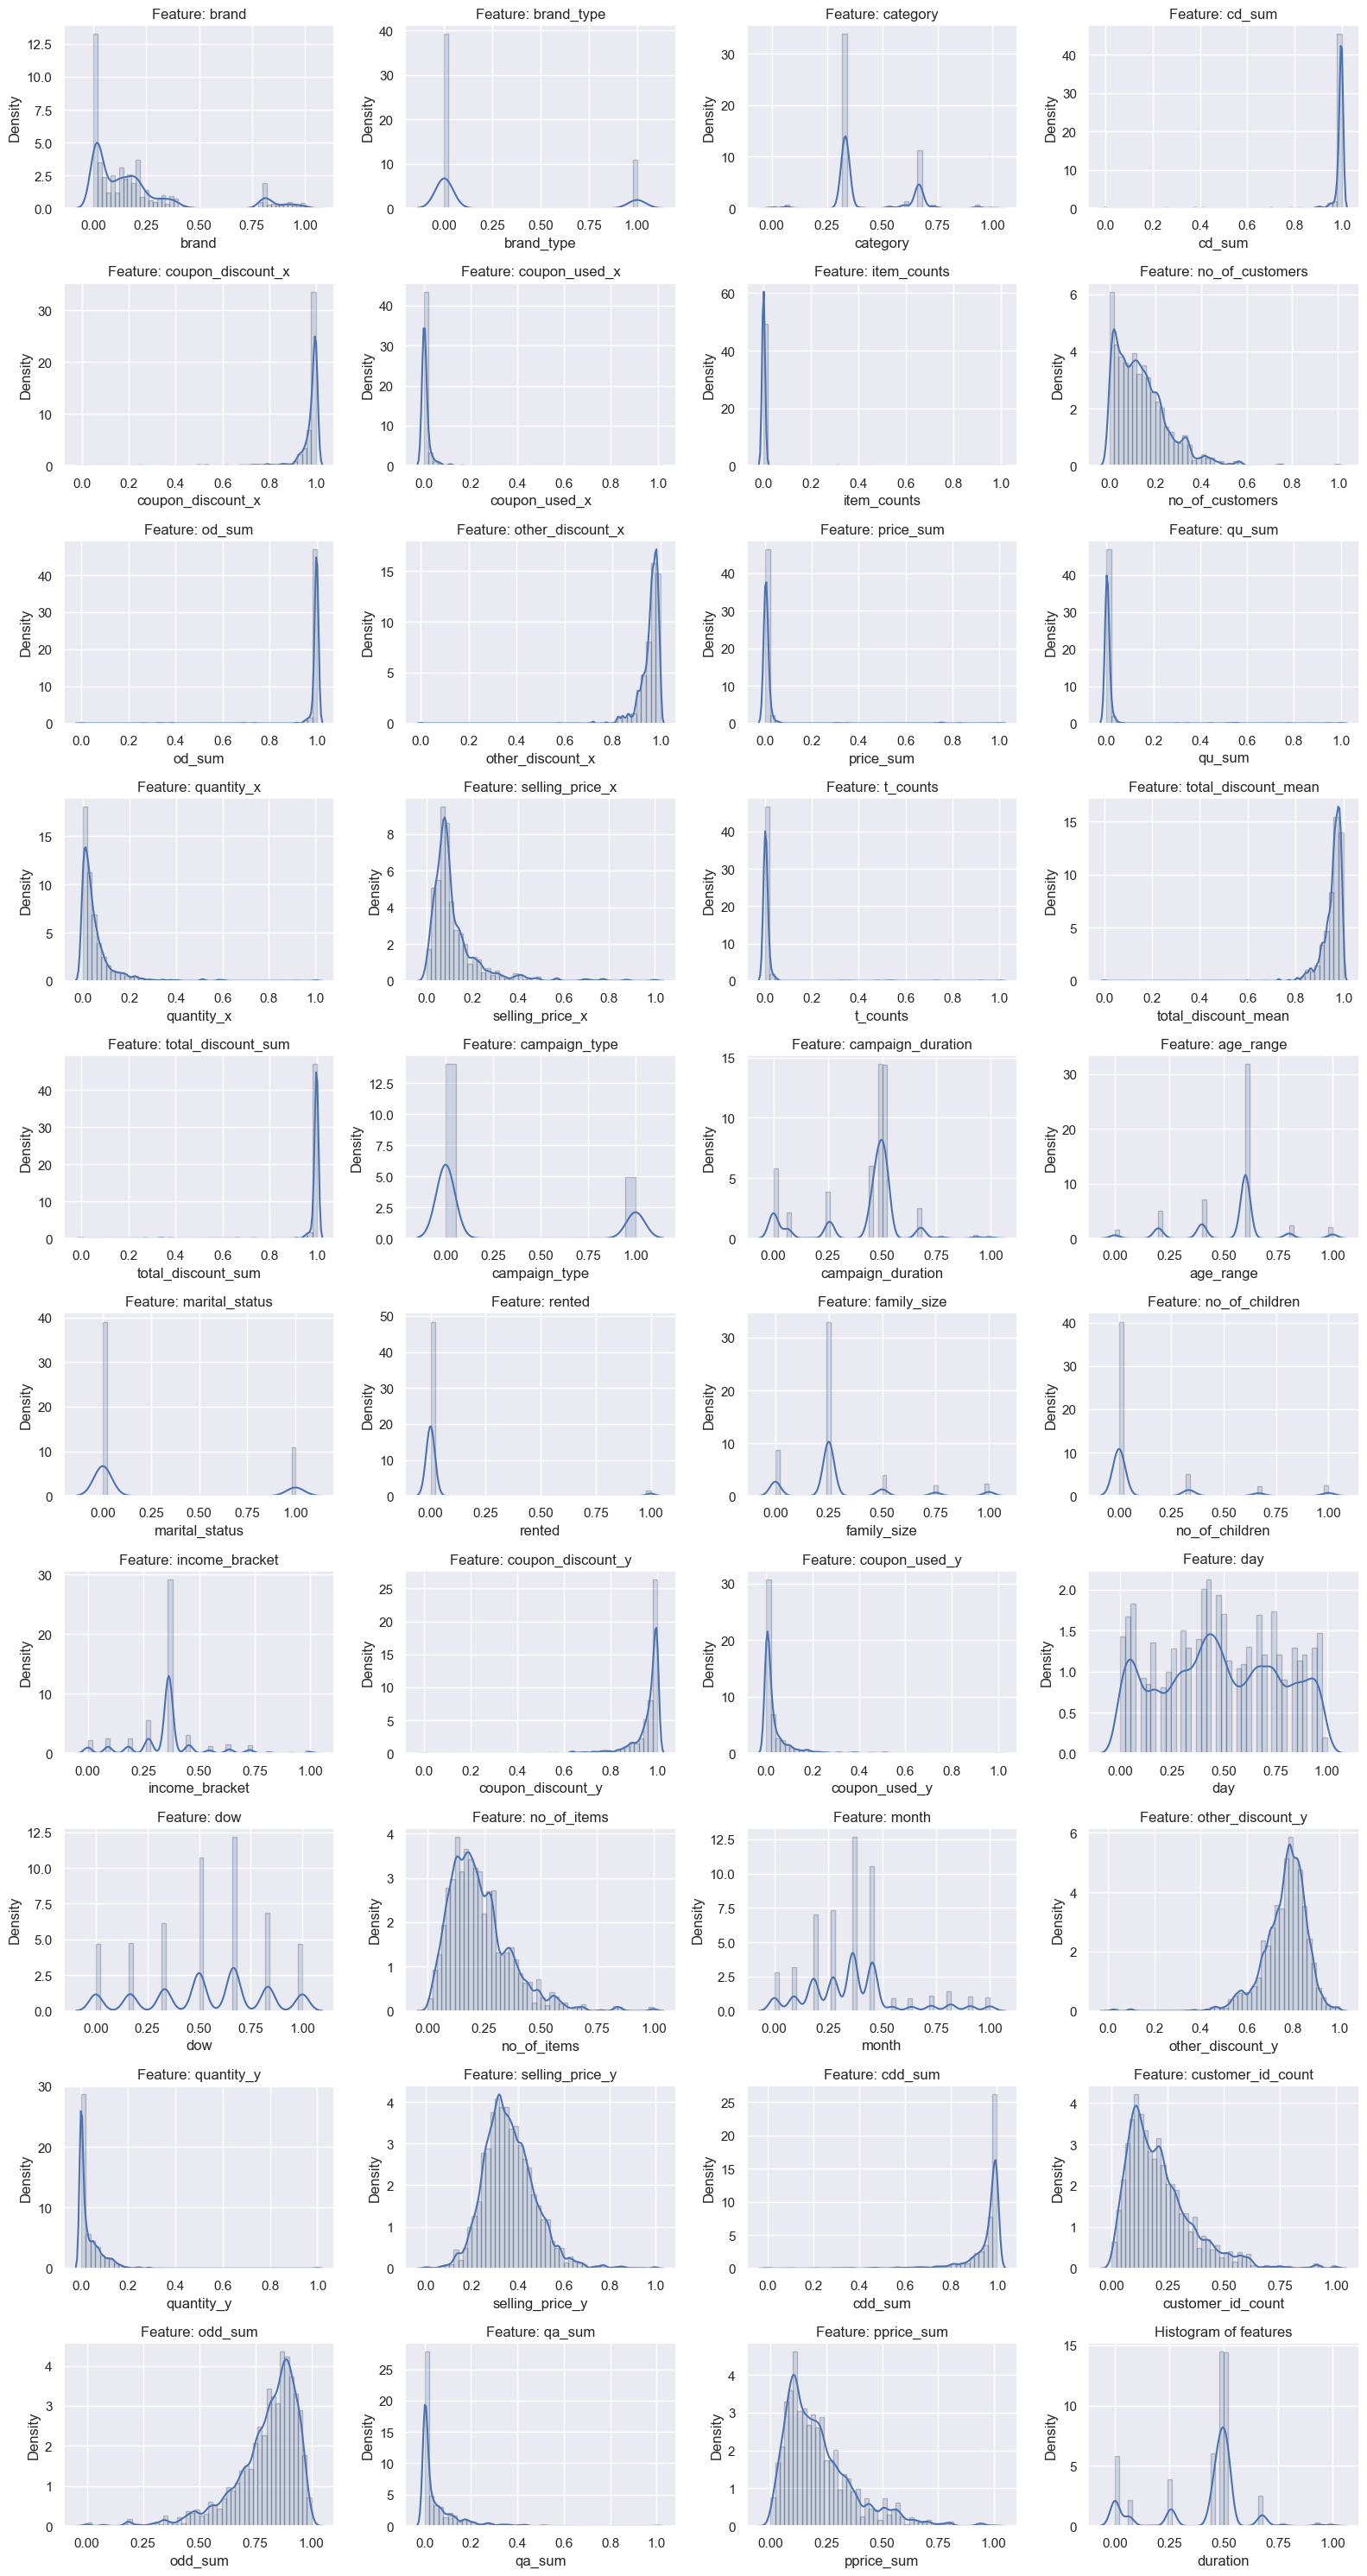

In [66]:
# Use seaborn to plot the histogram and kde of each feature
n = 4
m = 10

fig,ax = plt.subplots(m, n, figsize = (n * 4, m * 3)) # 13行，3列
axes = ax.flatten()

for i in range(10):
    for j in range(4):
        sns.distplot(Xtrain_[Xtrain_.columns[i * 4 + j]], ax = axes[i * 4 + j], 
                    hist_kws = {'edgecolor':'black', 'alpha': 0.2})
        axes[i * 4 + j].set_title('Feature: {}'.format(Xtrain_.columns[i * 4 + j]))
plt.title('Histogram of features')
fig.tight_layout()
plt.show()

Most features are tilted, so we need to logarithmize them

In [67]:
# Logarithmize
Xtrain_2 = Xtrain_.apply(lambda x: np.log(x + 1))
Xtest_2 = Xtest_.apply(lambda x: np.log(x + 1))

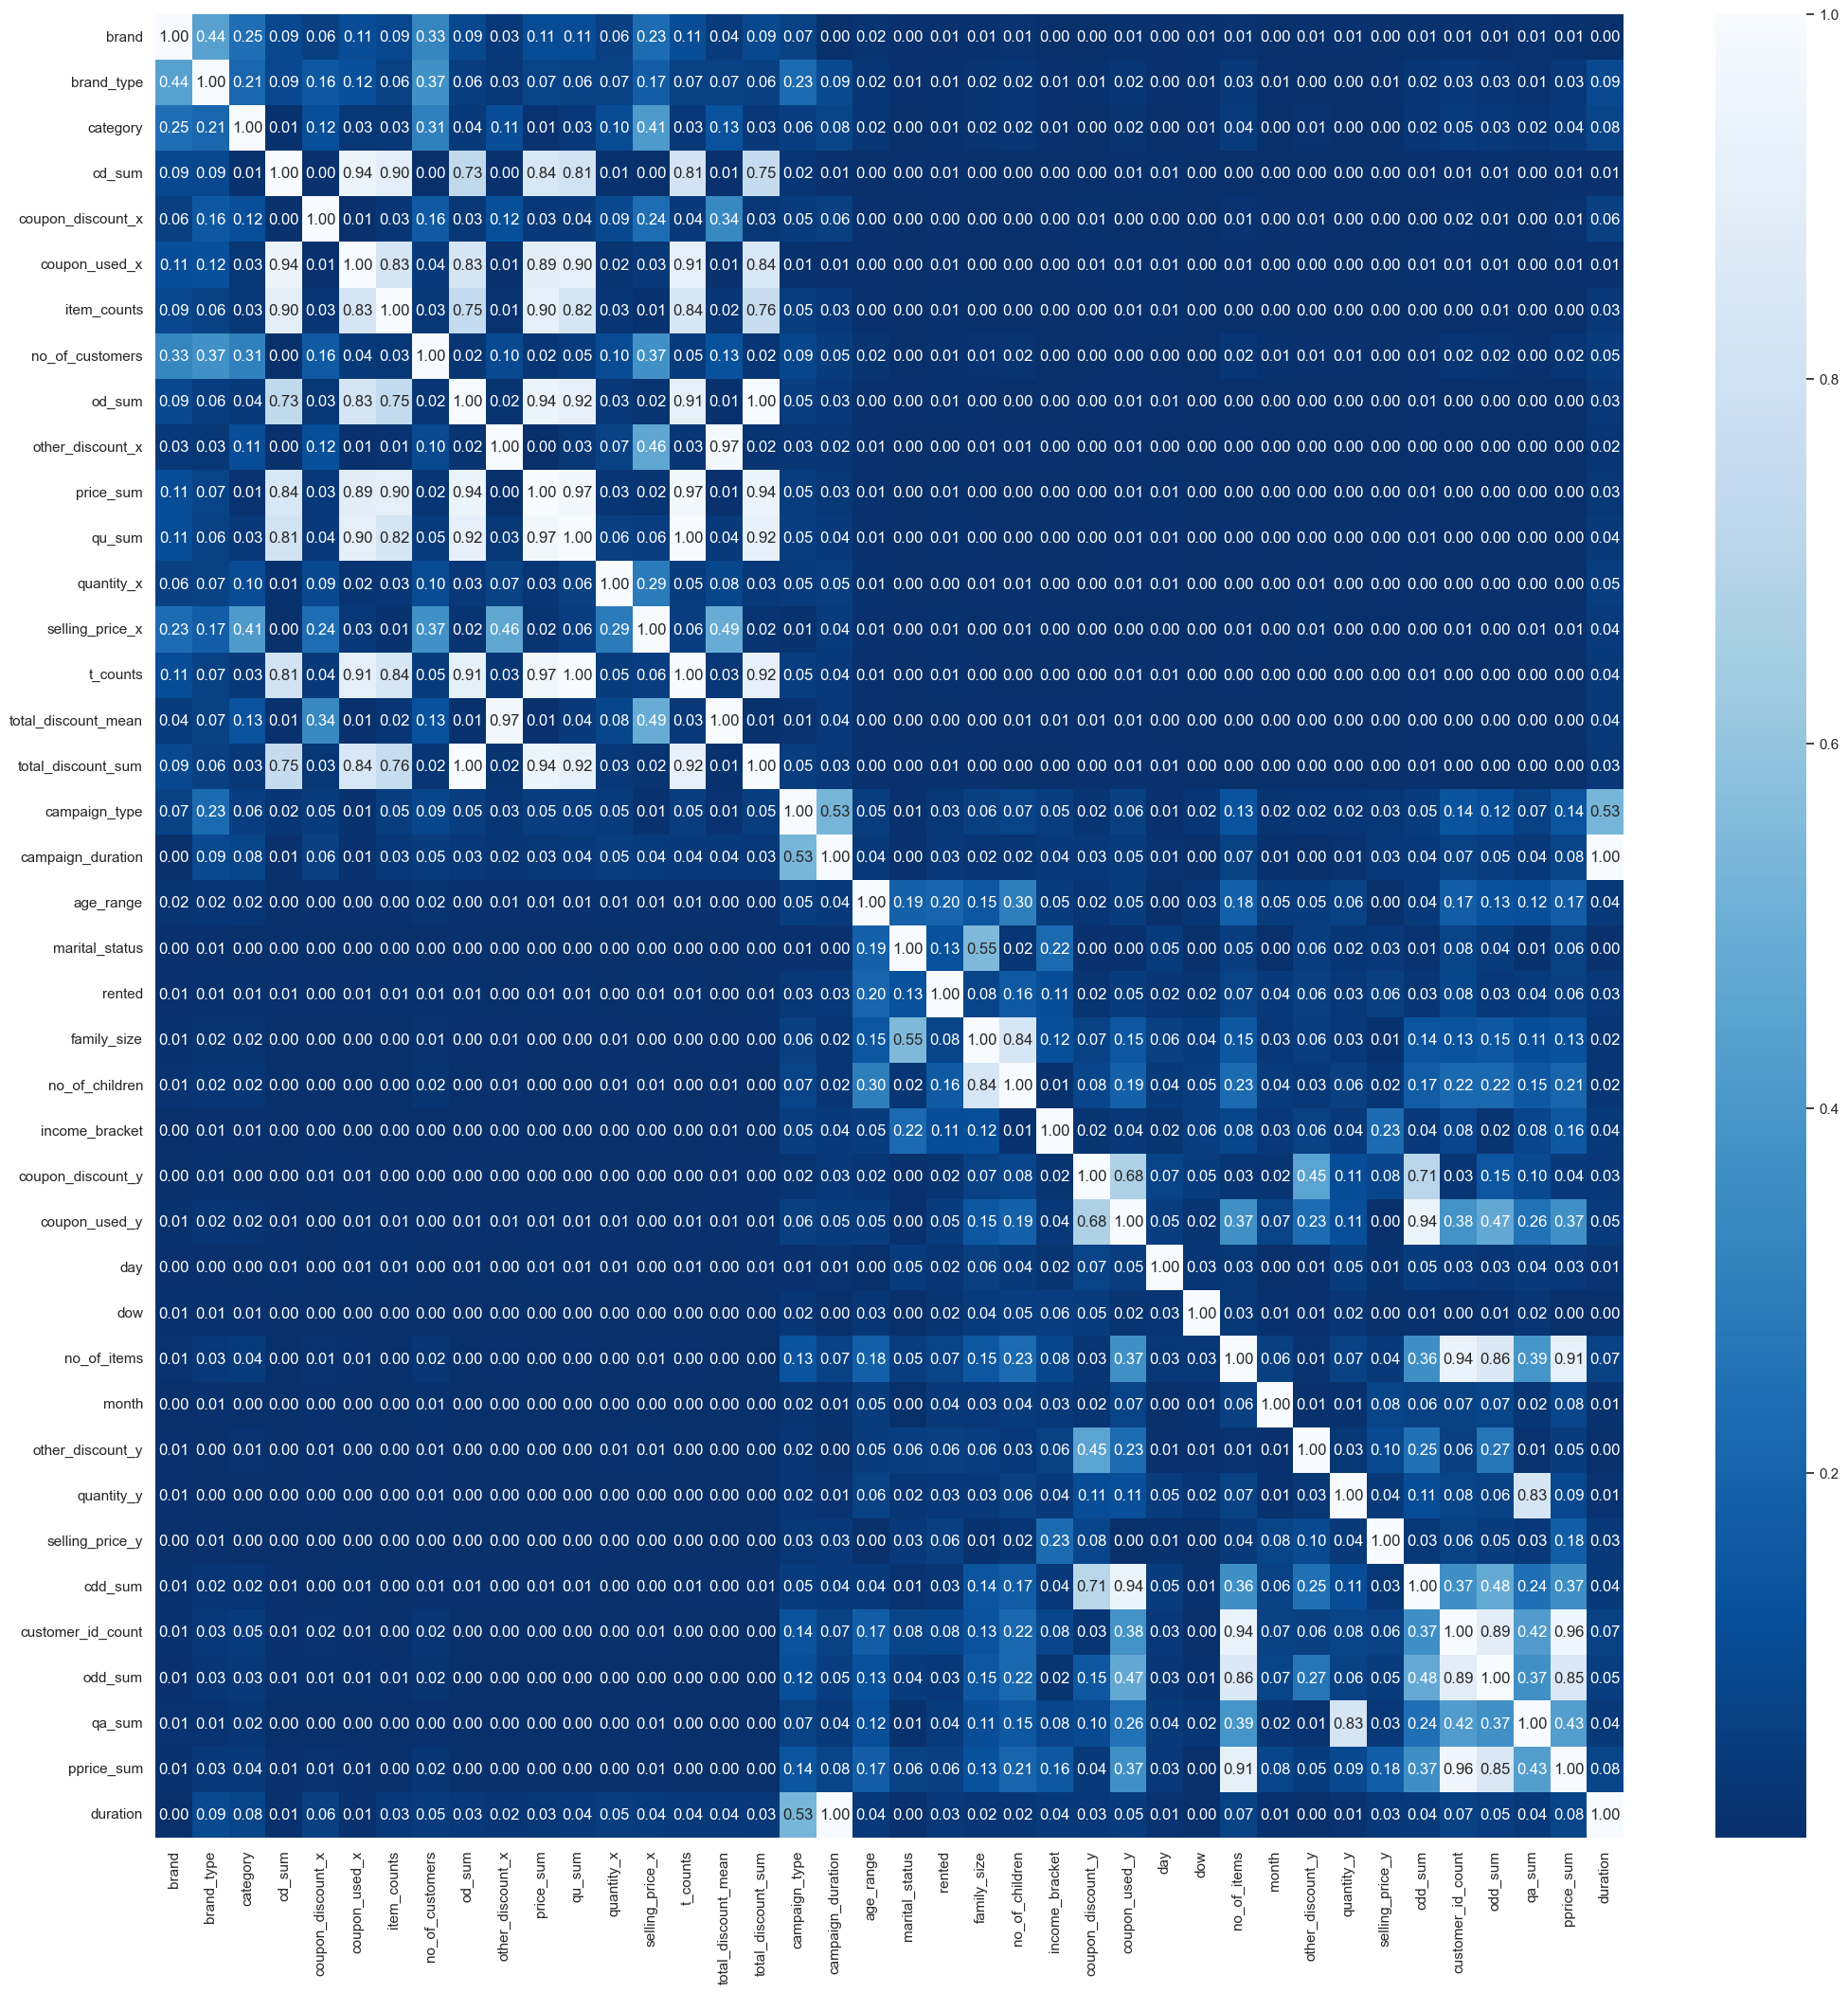

In [68]:
# Check the correlation between features
c = Xtrain_2.corr()
plt.figure(figsize = (25,25))
fig = sns.heatmap(np.abs(c), annot = True, fmt = '.2f', cmap = 'Blues_r')
plt.show()

The lighter the color of the heat map, the greater the covariance between the two features.
Therefore, it can be seen that there is covariance in some features.
We can use PCA to reduce the dimensionality to eliminate the covariance

### 3.5 Feature filtering and selection

Strategies:
1. Use the feature_importance_property of RandomForestClassifier to find the top 20 most important features.
2. Use chi-square test to select the top 20 important features.
3. Combine the two feature filtering results and take the intersection of the two results.
4. Use PCA to reduce the dimensionality.
5. Use Wrapper to select features
6. Compare the abovementioned three situations: (1) RFC + chi2, (2) PCA, (3) Wrapper

#### Use random forest classifier to select 20  features

In [69]:
rfc = RandomForestClassifier(n_estimators = 100, 
                             n_jobs = -1, 
                             random_state = 420)
rfc = rfc.fit(Xtrain_2, Ytrain)

In [72]:
# Sort feature importance in ascending order
importances = rfc.feature_importances_
indices = np.argsort(importances)[::-1]

for i in range(len(indices)):
    print('{:2d}: feature {:20s} \'s importance is {:.4f}'.format(
                                                                    i+1,
                                                                    Xtrain_2.columns[indices[i]],
                                                                    importances[indices[i]])
         )

 1: feature coupon_used_y        's importance is 0.0537
 2: feature cdd_sum              's importance is 0.0486
 3: feature coupon_discount_y    's importance is 0.0427
 4: feature selling_price_y      's importance is 0.0362
 5: feature quantity_y           's importance is 0.0354
 6: feature odd_sum              's importance is 0.0354
 7: feature other_discount_y     's importance is 0.0352
 8: feature qa_sum               's importance is 0.0336
 9: feature pprice_sum           's importance is 0.0325
10: feature cd_sum               's importance is 0.0314
11: feature coupon_used_x        's importance is 0.0309
12: feature customer_id_count    's importance is 0.0308
13: feature od_sum               's importance is 0.0306
14: feature day                  's importance is 0.0305
15: feature no_of_items          's importance is 0.0303
16: feature price_sum            's importance is 0.0292
17: feature t_counts             's importance is 0.0292
18: feature coupon_discount_x  

In [73]:
# Select first 20 features
rfc_features = []
for i in range(20):
    rfc_features.append(Xtrain_2.columns[indices[i]])

#### Use chi-square test to select 20  features

In [74]:
fschi = SelectKBest(chi2, k = 20).fit(Xtrain_2, Ytrain)
col = fschi.get_support()
fschi_features = list(Xtrain_2.columns[col])
print(fschi_features)

['brand', 'brand_type', 'coupon_used_x', 'item_counts', 'no_of_customers', 'price_sum', 'qu_sum', 't_counts', 'campaign_type', 'marital_status', 'rented', 'no_of_children', 'coupon_used_y', 'no_of_items', 'quantity_y', 'cdd_sum', 'customer_id_count', 'odd_sum', 'qa_sum', 'pprice_sum']


#### Choose intersection of two results

In [80]:
combined_col = list(set(rfc_features).union (set(fschi_features)))
print(combined_col)
print('There are {} features in total'.format(len(combined_col)))

['no_of_customers', 'odd_sum', 'item_counts', 'brand', 'qu_sum', 'coupon_discount_x', 'day', 'cdd_sum', 'qa_sum', 'no_of_children', 'quantity_y', 'coupon_used_y', 'pprice_sum', 'coupon_discount_y', 'customer_id_count', 'no_of_items', 't_counts', 'cd_sum', 'coupon_used_x', 'rented', 'other_discount_y', 'brand_type', 'price_sum', 'campaign_type', 'marital_status', 'od_sum', 'total_discount_sum', 'selling_price_y']
There are 28 features in total


#### PCA

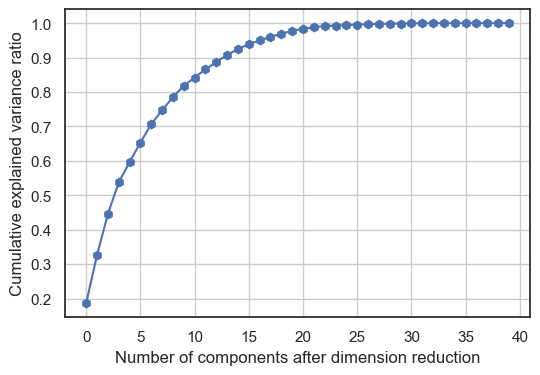

In [116]:
pca_ = PCA().fit(Xtrain_2)

sns.set(style = 'white')
plt.figure(figsize = (6, 4))
plt.grid()
plt.plot(np.cumsum(pca_.explained_variance_ratio_), marker = 'h')   # Cumulative variance contribution ratio
plt.xlabel("Number of components after dimension reduction")
plt.ylabel("Cumulative explained variance ratio")
plt.show()          

In [90]:
# Reduce to 25 features
pca_ = PCA(n_components = 25).fit(Xtrain_2)

In [91]:
# Training set
Xtrain_pca = pca_.transform(Xtrain_2)
# Test set
Xtest_pca = pca_.transform(Xtest_2)

#### Wrapper

In [94]:
# learning curve of 'n_features_to_select'
roc = []
for i in range(20,41,5):
    # Instantiate a logistic regression model to evaluate the effect of wrapper
    lr = LogisticRegression(n_jobs = -1)
    selector = RFE(lr, n_features_to_select = i).fit(Xtrain_2, Ytrain)
    
    # Training set and test set after wrapper
    train_wrapper = selector.transform(Xtrain_2)
    test_wrapper = selector.transform(Xtest_2)
    
    # Use training set to train the model
    lr_ = LogisticRegression(n_jobs = -1).fit(train_wrapper, Ytrain)
    
    # predicted y in test set
    y_predict = lr_.predict_proba(test_wrapper)[:, 1]
    
    # calculate roc-auc
    FPR, recall, thresholds = roc_curve(Ytest,y_predict)
    roc_auc = auc(FPR,recall)
    roc.append(roc_auc)

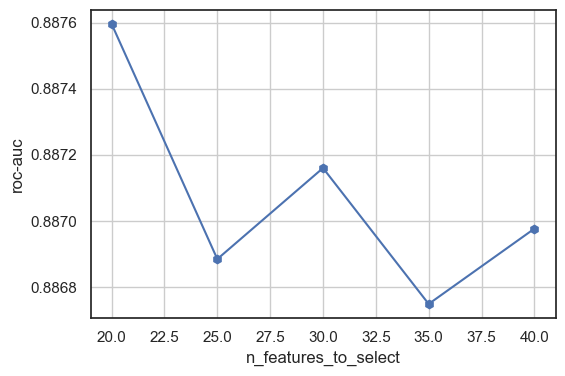

In [117]:
sns.set(style = 'white')
plt.figure(figsize = (6,4))
plt.grid()
plt.plot(range(20,41,5), roc, marker = 'h')
plt.xlabel('n_features_to_select')
plt.ylabel('roc-auc')
plt.show()

According to the plot, we choose 20 features in wrapper method

In [101]:
selector = RFE(lr, n_features_to_select = 20).fit(Xtrain_2, Ytrain)
train_wrapper = selector.transform(Xtrain_2)
test_wrapper = selector.transform(Xtest_2)

#### Compare the effect of different feature engneerng methods

In [102]:
# Define a function to calculate auc-score 
def custom_socre(y_true, x_true, net):
    FPR, recall, thresholds = roc_curve(y_true, net.predict_proba(x_true)[:,1])
    auc_score = auc(FPR, recall)
    return auc_score

In [112]:
# Define a function to draw roc-auc curve
def compare_feature_selection(x_train, x_test, y, title):
    lr = LogisticRegression(n_jobs = -1).fit(x_train, Ytrain)
    y_p = lr.predict_proba(x_test)[:, 1]
    FPR, recall, thresholds = roc_curve(y,y_p)
    roc_auc = auc(FPR,recall)
    
    ## Draw roc curve
    plt.figure(figsize = (6, 3))
    plt.plot(FPR, recall, lw = 2, label='ROC curve (area = %0.4f)' % roc_auc)
    plt.plot([0, 1], [0, 1], lw=2, linestyle='--')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title);
    plt.legend(loc="lower right", fontsize = 12)
    plt.show()

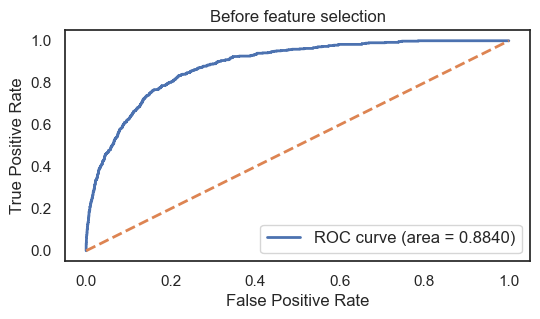

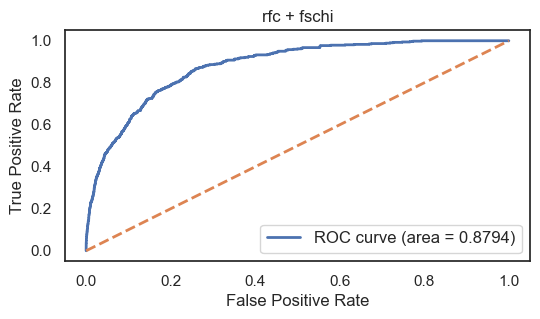

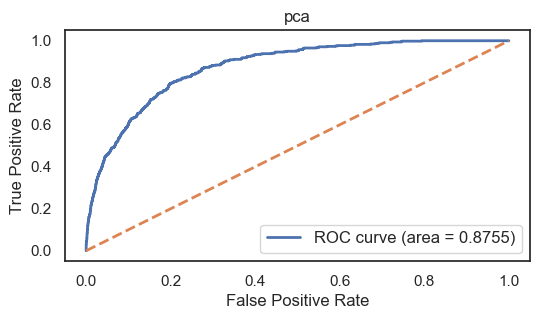

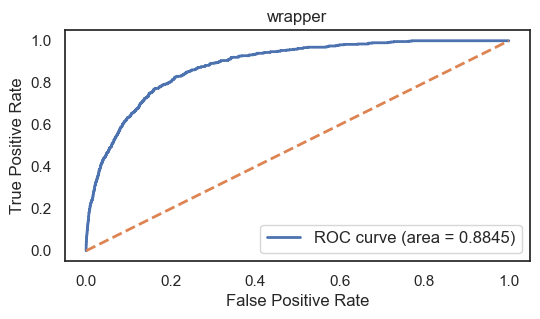

In [113]:
# For training set:
compare_feature_selection(Xtrain_2, Xtrain_2, Ytrain, 'Before feature selection')
compare_feature_selection(Xtrain_2[combined_col], Xtrain_2[combined_col], Ytrain, 'rfc + fschi')
compare_feature_selection(Xtrain_pca, Xtrain_pca, Ytrain, 'pca')
compare_feature_selection(train_wrapper, train_wrapper, Ytrain, 'wrapper')

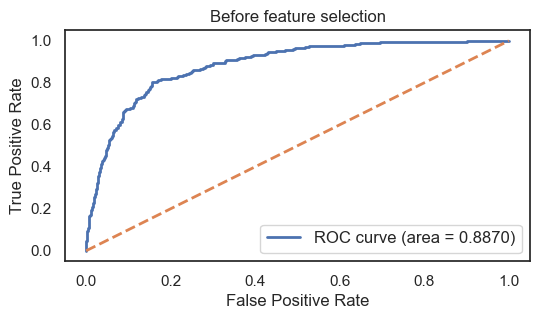

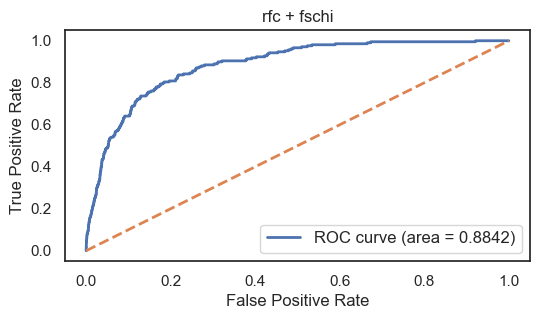

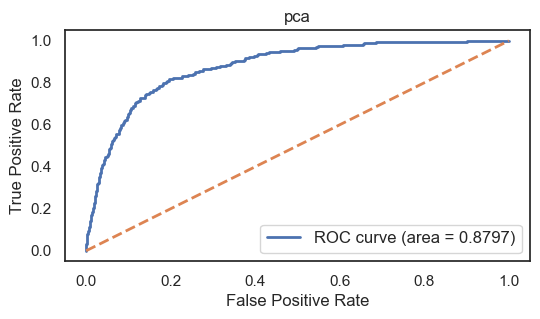

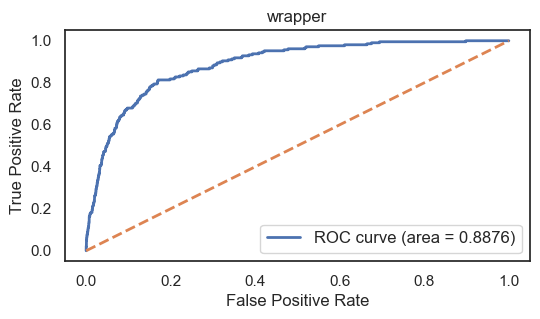

In [114]:
# For test set:
compare_feature_selection(Xtrain_2, Xtest_2, Ytest, 'Before feature selection')
compare_feature_selection(Xtrain_2[combined_col], Xtest_2[combined_col], Ytest, 'rfc + fschi')
compare_feature_selection(Xtrain_pca, Xtest_pca, Ytest, 'pca')
compare_feature_selection(train_wrapper, test_wrapper, Ytest, 'wrapper')

Compare the roc-auc score of the logistic regression model using differenct features, features after wrapper method show the best performance.  

In [115]:
# Use wrapper as feature engineering method
train_wrapper = pd.DataFrame(train_wrapper)
test_wrapper = pd.DataFrame(test_wrapper)

### 3.6 Discretization

Discretization can discretize continious variables, reducing the risk of overfitting

In [118]:
# record the threshold of each bin
def equal_distance_cut(data,bins):  
    Cutpoint = {}
    for i in range(len(data.columns)):
        cut = (np.max(data.iloc[:, i]) - np.min(data.iloc[:, i])) / bins
        Cutpointlist = []
        for j in range((bins - 1)):
            cutpoint = np.min(data.iloc[:, i]) + (j + 1) * cut
            Cutpointlist.append(cutpoint)
        Cutpoint[i] = Cutpointlist
    return Cutpoint

In [119]:
# use the threshold to discretize training and test sets
def apply_on_train_and_test(train, test, bins): 
    Cutpoint = equal_distance_cut(train, 10)
    train_set = pd.DataFrame(np.zeros_like(train), columns = train.columns, index = train.index)
    test_set = pd.DataFrame(np.zeros_like(test),columns = test.columns,index = test.index)
    for i in range(len(train.columns)):
        for j in range((bins - 1)):
            train_set.iloc[:, i][train.iloc[:, i] > Cutpoint[i][j]] = j
    for i in range(len(test.columns)):
        for j in range((bins - 1)):
            test_set.iloc[:, i][test.iloc[:, i] > Cutpoint[i][j]] = j
    return train_set, test_set

In [120]:
# how does number of bins affect model performance
results = []
for i in range(6, 11):
    bin_features_train, bin_features_test = apply_on_train_and_test(train_wrapper, test_wrapper, i) 
    # use random forest classifier to compare model performance under different discretization bins
    rfc = RandomForestClassifier(n_estimators = 200,
                                 max_depth = 10,
                                 n_jobs = -1,
                                 random_state = 0)
    rfc.fit(bin_features_train, Ytrain)
    rfc_prba = rfc.predict_proba(bin_features_test)[:, 1] 
    fpr, tpr, thresholds = roc_curve(Ytest, rfc_prba)
    roc_auc = auc(fpr, tpr)
    results.append(roc_auc)
for i in range(len(results)):
    print('bin = {}，auc of training data = {:.4f}'.format(i + 6, results[i]))

bin = 6，auc of training data = 0.8816
bin = 7，auc of training data = 0.8807
bin = 8，auc of training data = 0.8786
bin = 9，auc of training data = 0.8814
bin = 10，auc of training data = 0.8865


When bin = 10, auc is the highest, but still less than that before discretization. Therefore, we don't apply this method in this analysis

## 4. Build machine learning model 

### 4.1 Random Forest Classifier

In [121]:
param_rf = {'n_estimators': range(1,601,100),
            'max_depth': range(1,20,4),
            'min_samples_leaf': np.arange(1,10,2)}

In [122]:
# Grid Serach
rfc = RandomForestClassifier(class_weight='balanced', random_state = 420)  

param_rf = {'n_estimators': range(1,601,100),
            'max_depth': range(1,20,4), 
            'min_samples_leaf': np.arange(1,10,2)}

gs_rf = GridSearchCV(estimator = rfc,
                     param_grid = param_rf,
                     cv = 5,
                     scoring = 'roc_auc'
                    ).fit(train_wrapper, Ytrain)

In [126]:
print(gs_rf.best_params_)

{'max_depth': 13, 'min_samples_leaf': 5, 'n_estimators': 401}


In [124]:
# Define a function to plot roc curve
def plot_auc(model,x,y,title):
    y_p = model.predict_proba(x)[:, 1]
    FPR, recall, thresholds = roc_curve(y,y_p)
    roc_auc = auc(FPR,recall)

    plt.plot(FPR, recall, lw=2, label='ROC curve (area = %0.4f)' % roc_auc);
    plt.plot([0, 1], [0, 1], lw=2, linestyle='--');
    plt.xlim([-0.05, 1.05]);
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate');
    plt.ylabel('True Positive Rate');
    plt.title(title);
    plt.legend(loc="lower right");
    plt.show()

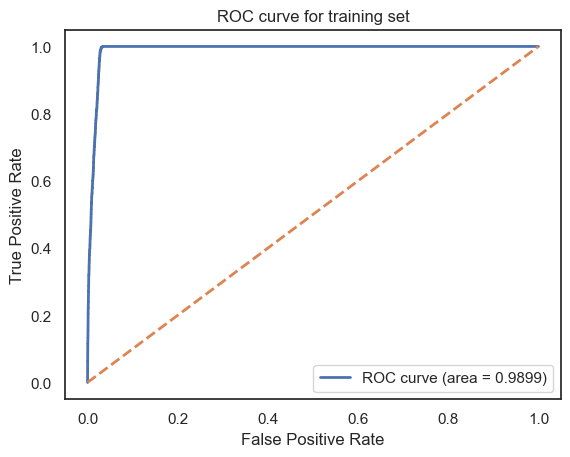

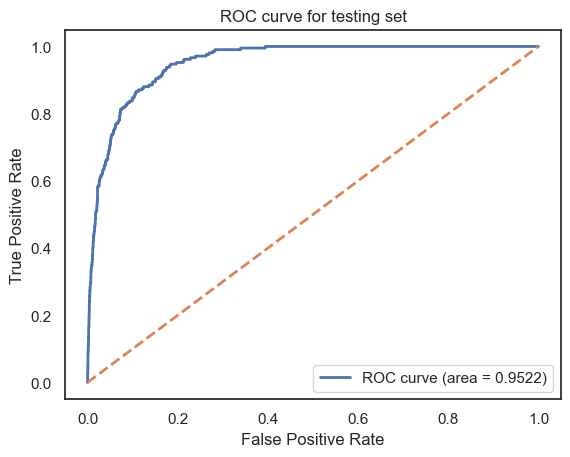

In [125]:
# plot the roc curve of training set and test set under the best parameters
rfc_best = RandomForestClassifier(n_estimators = 401, 
                                  max_depth = 13,
                                  min_samples_leaf = 5,
                                  class_weight = 'balanced',
                                  random_state = 420)
rfc_best.fit(train_wrapper, Ytrain)

plot_auc(rfc_best, train_wrapper, Ytrain, 'ROC curve for training set')
plot_auc(rfc_best, test_wrapper, Ytest, 'ROC curve for testing set')

Besides roc-auc score, precision is also an important metric in this case. Precision is the indicator of the quality of a positive prediction made by the model. It refers to the number of true positives divided by the total number of positive predictions. In this case, we want to identify the customers who make a purchase after we send them coupons so that the next time when we send coupons, the customer who receive them will buy the products in our website, thus increasing revenue. We don't want to waste our time and effort sending coupons to those customers who will not contribute to our profit enhancement.

In [132]:
# check the precision 
# calculate y_pred
y_tr_pred = rfc_best.predict(train_wrapper)
y_te_pred = rfc_best.predict(test_wrapper)

# confusion matrix
cm_tr = cm(Ytrain,y_tr_pred)
cm_te = cm(Ytest, y_te_pred)

# calculate precision
pr_tr = cm_tr[0,0] / (cm_tr[0,0] + cm_tr[1,0])
pr_te = cm_te[0,0] / (cm_te[0,0] + cm_te[1,0])
print('Precision in training set is: ', pr_tr)
print('Precision in test set is: ', pr_te)

Precision in training set is:  1.0
Precision in test set is:  0.9967068666280985


Both precision score and roc-auc score are high in training and test sets

### 4.2 XGBoost

In [135]:
# Use grid search to find the best combination of eta and n_estimators
clf = XGBC(random_state = 420)
param_xgbc = {'n_estimators': range(1,500,100), 
              'learning_rate':[0.05,0.1,0.2,0.3]
             }
gs_xgbc = GridSearchCV(clf, 
                      param_grid = param_xgbc,
                      cv = 5,
                      scoring = 'roc_auc').fit(train_wrapper, Ytrain)

In [136]:
print(gs_xgbc.best_params_)

{'learning_rate': 0.1, 'n_estimators': 101}


In [137]:
# use the optimal parameters
clf_bst = XGBC(n_estimators = 101,
           learning_rate = 0.1,
           random_state = 420).fit(train_wrapper,Ytrain)
print("\tAUC for train:{}".format(custom_socre(y_true=Ytrain, x_true=train_wrapper, net=clf_bst)))
print("\tAUC for test:{}".format(custom_socre(y_true=Ytest, x_true=test_wrapper, net=clf_bst)))

	AUC for train:0.986891823118543
	AUC for test:0.9539141556734354


In [138]:
# use grid search to adjust other parameters
clf = XGBC(n_estimators = 101,
           learning_rate = 0.1,
           random_state = 420)
param_xgbc = {'scale_pos_weight': [1, 5, 10, 20, 30], 
              'gamma':[0.05, 0.1, 0.5, 1, 5],
              'reg_lambda': [0, 0.1, 0.5, 1, 5]
             }
gs_xgbc = GridSearchCV(clf, 
                      param_grid = param_xgbc,
                      cv = 5,
                      scoring = 'roc_auc').fit(train_wrapper, Ytrain)

In [139]:
print(gs_xgbc.best_params_)

{'gamma': 0.05, 'reg_lambda': 5, 'scale_pos_weight': 1}


In [140]:
# use the optimal parameters
clf_bst = XGBC(n_estimators = 101,
               learning_rate = 0.1,
               gamma = 0.05,
               reg_lambda = 5,
               scale_pos_weight = 1,
               random_state = 420).fit(train_wrapper,Ytrain)
print("\tAUC for train:{}".format(custom_socre(y_true=Ytrain, x_true=train_wrapper, net=clf_bst)))
print("\tAUC for test:{}".format(custom_socre(y_true=Ytest, x_true=test_wrapper, net=clf_bst)))

	AUC for train:0.9795041612754356
	AUC for test:0.9531216697418831


auc score decreases compared to the last model

In [141]:
# use the parameters in the first try
clf_bst = XGBC(n_estimators = 101,
           learning_rate = 0.1,
           random_state = 420).fit(train_wrapper,Ytrain)

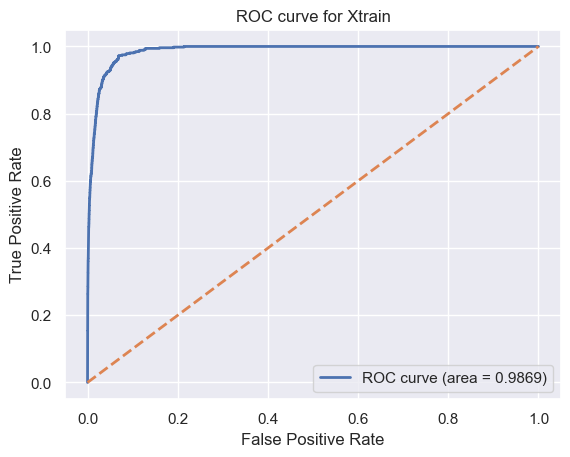

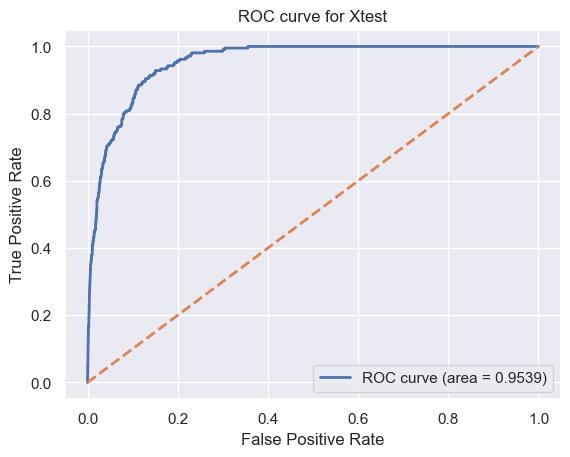

In [142]:
# plot roc-auc curves
plot_auc(clf_bst, train_wrapper, Ytrain, 'ROC curve for Xtrain')
plot_auc(clf_bst, test_wrapper, Ytest, 'ROC curve for Xtest')

In [143]:
# check precision
# y_pred
y_tr_pred = clf_bst.predict(train_wrapper)
y_te_pred = clf_bst.predict(test_wrapper)

# confusion matrix
cm_tr = cm(Ytrain,y_tr_pred)
cm_te = cm(Ytest, y_te_pred)

# calculate precision
pr_tr = cm_tr[0,0] / (cm_tr[0,0] + cm_tr[1,0])
pr_te = cm_te[0,0] / (cm_te[0,0] + cm_te[1,0])
print('Precision of training set is :', pr_tr)
print('Precision of test set is :', pr_te)

Precision of training set is : 0.9916592141045062
Precision of test set is : 0.9913184100774534


xgb model performs better than the random forest classifier, so we use xgb model eventually. 